In [1]:
import numpy as np 
import pandas as pd
import os
import librosa
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler,StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

In [2]:
def extract_audio(path,samprate):
    features={}
    audio, sr = librosa.load(path, sr=samprate)
    features['duration'] = librosa.get_duration(y=audio, sr=sr)
    features['mfcc'] = librosa.feature.mfcc(y=audio, sr=sr)  # Mel Frequency Cepstral Coefficients
    features['chroma'] = librosa.feature.chroma_stft(y=audio, sr=sr)  # Chroma Feature
    features['spectral_contrast'] = librosa.feature.spectral_contrast(y=audio, sr=sr)  # Spectral Contrast
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    tempo, beat_frames = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    features['beat_frames']=beat_frames
    features['rms'] = librosa.feature.rms(y=audio)
    features['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features['spectral_rolloff'] = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    return features

In [3]:
def cleaning(df_combined):
    X_df=df_combined.drop(columns=['Id','ethnicity','sampling_rate','path'])
    X_df['tempo'] = X_df['tempo'].str.strip('[]').astype('float64')
    return X_df

In [4]:
def meandf(df_copy):
    duration=df_copy['duration']
    df_copy=df_copy.drop(columns=['duration'])
    colonne=len(df_copy.columns)
    dizionario={}
    for j in range(colonne):
        dizionario[j]=[]
    for j in range(colonne):
        for i in range(len(df_copy)):
            if df_copy.iloc[i,j].ndim>1:
                dizionario[j].append(df_copy.iloc[i,j].std(axis=1))
                df_copy.iloc[i, j] = df_copy.iloc[i, j].mean(axis=1)
            else:
                dizionario[j].append(df_copy.iloc[i,j].std())
                df_copy.iloc[i, j] = df_copy.iloc[i, j].mean()
    for key in dizionario.keys():
        df_copy[df_copy.columns[key] + '_std']=dizionario[key]
    expanded_df = pd.DataFrame()
    for col in df_copy.columns:
        expanded = df_copy[col].apply(pd.Series)
        expanded.columns = [f'{col}_{i+1}' for i in expanded.columns]
        expanded_df = pd.concat([expanded_df, expanded], axis=1)
    expanded_df['duration']=duration
    return expanded_df

In [5]:
def encoding(df1,df2):
    encoder1 = LabelEncoder()
    df1['gender']=encoder1.fit_transform(df1['gender'])
    df1['ch/s']=df1['num_characters']/(df1['duration'])
    df2['gender']=df2['gender'].replace('famale','female')
    df2['gender']=encoder1.transform(df2['gender'])
    df2['ch/s']=df2['num_characters']/(df2['duration'])
    unique_ethnicities = ['igbo','english','arabic' ]
    df2['ethnicity_mapped'] = df2['ethnicity'].apply(lambda x: x if x in unique_ethnicities else 'Other')
    df1['ethnicity_mapped'] = df1['ethnicity'].apply(lambda x: x if x in unique_ethnicities else 'Other')
    encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
    X_train_encoded = encoder.fit_transform(df1[['ethnicity_mapped']])
    X_test_encoded = encoder.transform(df2[['ethnicity_mapped']])
    columns = encoder.get_feature_names_out(['ethnicity_mapped'])
    X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=columns, index=df1.index)
    X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=columns, index=df2.index)
    df1_final = df1.drop('ethnicity_mapped', axis=1).join(X_train_encoded_df)
    df2_final = df2.drop('ethnicity_mapped', axis=1).join(X_test_encoded_df)
    return df1_final, df2_final

In [6]:
dev_df=pd.read_csv("DSL_Winter_Project_2025/development.csv")
eval_df=pd.read_csv("DSL_Winter_Project_2025/evaluation.csv")

In [7]:
freq_df1 = dev_df['ethnicity'].value_counts(normalize=True) * 100
freq_df2 = eval_df['ethnicity'].value_counts(normalize=True) * 100
freq_df1_sorted = freq_df1.sort_values(ascending=False)
freq_df2_sorted = freq_df2.sort_values(ascending=False)
print("Top 5 ethnicity in dev_df:")
print(freq_df1_sorted.head(5))
print("\nTop 5 ethnicity in eval_df:")
print(freq_df2_sorted.head(5))


Top 5 ethnicity in dev_df:
ethnicity
igbo        36.856461
english     19.740880
arabic       3.477668
mandarin     2.216161
french       2.147971
Name: proportion, dtype: float64

Top 5 ethnicity in eval_df:
ethnicity
igbo          33.574530
spanish       23.444284
turkish        5.354559
vietnamese     3.183792
swedish        2.894356
Name: proportion, dtype: float64


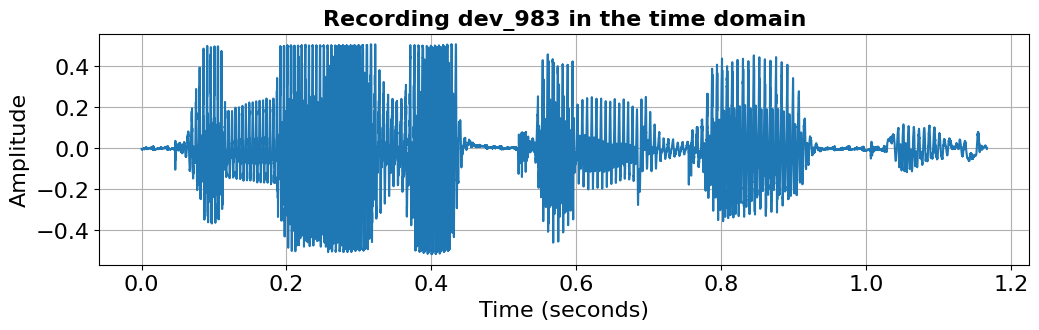

In [8]:
file_path = 'DSL_Winter_Project_2025//audios_development/983.wav'
ssr = dev_df.loc[982]["sampling_rate"]
y, sr = librosa.load(file_path, sr=ssr)
time = np.arange(len(y)) / sr
plt.figure(figsize=(12, 3))
plt.plot(time, y)
plt.title('Recording dev_983 in the time domain', fontsize=16, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=16)
plt.ylabel('Amplitude', fontsize=16,)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

In [9]:
display(dev_df.dtypes)

Id                          int64
sampling_rate               int64
age                       float64
gender                     object
ethnicity                  object
mean_pitch                float64
max_pitch                 float64
min_pitch                 float64
jitter                    float64
shimmer                   float64
energy                    float64
zcr_mean                  float64
spectral_centroid_mean    float64
tempo                      object
hnr                       float64
num_words                   int64
num_characters              int64
num_pauses                  int64
silence_duration          float64
path                       object
dtype: object

In [10]:
columns = ['mfcc', 'chroma', 'spectral_contrast','beat_frames','rms','spectral_bandwidth','spectral_rolloff','duration']
df=pd.DataFrame(columns=columns)
# Iterate through the paths in dev_df
for i in range(len(dev_df)):  
    path = dev_df.loc[i, 'path']
    path = os.path.join('DSL_Winter_Project_2025', path)
    features=extract_audio(path,dev_df.loc[i, 'sampling_rate'])
    df.loc[len(df)] = features
dfy=pd.DataFrame(columns=columns)
for i in range(len(eval_df)):
    path = eval_df.loc[i, 'path']
    path = os.path.join('DSL_Winter_Project_2025', path)
    featuresy=extract_audio(path,eval_df.loc[i, 'sampling_rate'])
    dfy.loc[len(dfy)] = featuresy

In [11]:
df_copy=df.copy()
dfy_copy=dfy.copy()
df_copy= meandf(df_copy)
dfy_copy= meandf(dfy_copy)
df_combined=pd.concat([dev_df,df_copy],axis=1)
dfy_combined=pd.concat([eval_df,dfy_copy],axis=1)
df1,df2=encoding(df_combined,dfy_combined)
X_df=cleaning(df1)
y=X_df['age']
X_df=X_df.drop(columns='age')
Y_df=cleaning(df2)

AVGTOTAL= 17.11751824570888


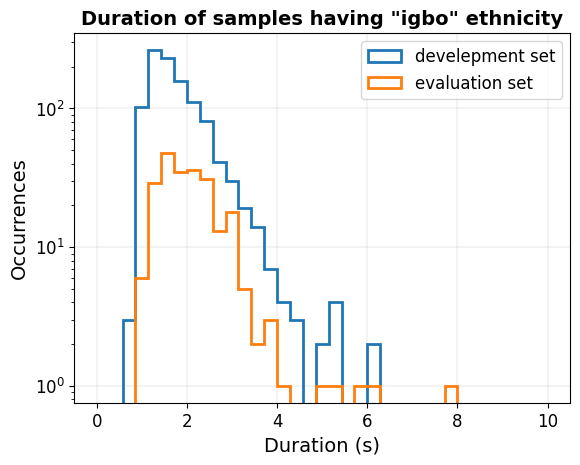

In [12]:
indices = dev_df[dev_df['ethnicity'] == 'igbo'].index
indices2=eval_df[eval_df['ethnicity']=='igbo'].index
selected_rows = X_df.loc[indices]
selected_rows2=Y_df.loc[indices2]
nsr=dev_df.loc[indices]
nsr2=eval_df.loc[indices2]
AVGTOTAL = (X_df["duration"].sum() + Y_df["duration"].sum()) / (len(X_df["duration"]) + len(Y_df["duration"]))
print("AVGTOTAL=", AVGTOTAL)
plt.hist(selected_rows["duration"], range=(0, 10), bins=35, histtype='step', label="develepment set", linewidth=2)
plt.hist(selected_rows2["duration"], range=(0, 10), bins=35, histtype='step', label="evaluation set", linewidth=2)
plt.yscale('log')
plt.title('Duration of samples having "igbo" ethnicity', fontsize=14,fontweight="bold")
plt.xlabel('Duration (s)', fontsize=14)
plt.ylabel('Occurrences', fontsize=14)
plt.grid(linewidth=0.2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [13]:
pipe_std_nopca = Pipeline([
    ('scaling', StandardScaler()),
    ('polynomial_feature', PolynomialFeatures()),
    ('classifier', Ridge()),
])
pipe_mm_nopca= Pipeline([
    ('scaling', MinMaxScaler()),
    ('polynomial_feature', PolynomialFeatures()),
    ('classifier', Ridge()),
])
pipe= Pipeline([
    ('polynomial_feature', PolynomialFeatures()),
    ('classifier', Ridge()),
])

In [14]:
param_grid = [
    {
        'classifier': [Lasso()],
        "classifier__alpha": [0.1,0.3,1,10],
        "classifier__fit_intercept": [True,False],
        'polynomial_feature__degree':[1,2]
    },
    {
        'classifier': [Ridge()],
        "classifier__alpha": [1,2,4.5,5,5.5,10],
        'classifier__fit_intercept': [True,False],
        'polynomial_feature__degree':[1,2],
        
    },
    {
        'classifier': [LinearRegression()],
        'classifier__fit_intercept': [True,False],
        'polynomial_feature__degree':[1]
    }
]
param_grid_no_scaler=[
    {
        'classifier': [RandomForestRegressor(random_state=42)],
        'classifier__n_estimators': [50,100],
        'classifier__max_depth': [5, 10, 50,100],
        'classifier__max_features':['log2', 'sqrt']
    }
]

In [15]:
gscv_mm_nopca = GridSearchCV(
    estimator=pipe_mm_nopca,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', 
    cv=5,
)
gscv_std_nopca = GridSearchCV(
    estimator=pipe_std_nopca,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
)
gscv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_no_scaler,
    scoring='neg_root_mean_squared_error',
    cv=5,
)

In [16]:
gscv_mm_nopca.fit(X_df, y)
gscv_std_nopca.fit(X_df, y)
gscv.fit(X_df, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomial_feature',
                                        PolynomialFeatures()),
                                       ('classifier', Ridge())]),
             param_grid=[{'classifier': [RandomForestRegressor(random_state=42)],
                          'classifier__max_depth': [5, 10, 50, 100],
                          'classifier__max_features': ['log2', 'sqrt'],
                          'classifier__n_estimators': [50, 100]}],
             scoring='neg_root_mean_squared_error')

Best config for Lasso: {'classifier': Lasso(), 'classifier__alpha': 0.1, 'classifier__fit_intercept': False, 'polynomial_feature__degree': 2}, Score: 10.5139
Best config for Ridge: {'classifier': Ridge(), 'classifier__alpha': 5.5, 'classifier__fit_intercept': False, 'polynomial_feature__degree': 2}, Score: 9.5629
Best config for LinearRegression: {'classifier': LinearRegression(), 'classifier__fit_intercept': False, 'polynomial_feature__degree': 1}, Score: 10.2310
Best config for Lasso: {'classifier': Lasso(), 'classifier__alpha': 0.3, 'classifier__fit_intercept': True, 'polynomial_feature__degree': 2}, Score: 9.7686
Best config for Ridge: {'classifier': Ridge(), 'classifier__alpha': 10, 'classifier__fit_intercept': True, 'polynomial_feature__degree': 1}, Score: 10.2150
Best config for LinearRegression: {'classifier': LinearRegression(), 'classifier__fit_intercept': False, 'polynomial_feature__degree': 1}, Score: 10.2315


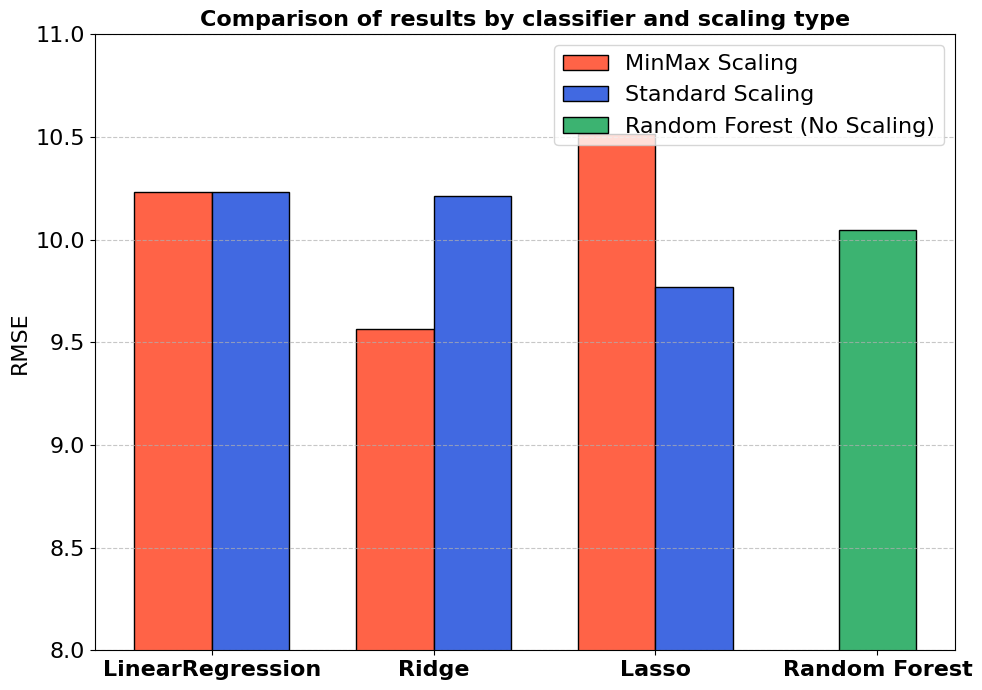

In [17]:
best_params_per_classifier = {}
for idx, params in enumerate(gscv_mm_nopca.cv_results_['params']):
    clf_type = params['classifier'].__class__.__name__
    score = np.abs(gscv_mm_nopca.cv_results_['mean_test_score'][idx] )
    if np.isnan(score):
        continue
    if clf_type not in best_params_per_classifier or score < best_params_per_classifier[clf_type]['score']:
        best_params_per_classifier[clf_type] = {
            'params': params,
            'score': score
        }
for clf, details in best_params_per_classifier.items():
    print(f"Best config for {clf}: {details['params']}, Score: {details['score']:.4f}")
best_params_std = {}
for idx, params in enumerate(gscv_std_nopca.cv_results_['params']):
    clf_type = params['classifier'].__class__.__name__
    score = np.abs(gscv_std_nopca.cv_results_['mean_test_score'][idx])
    if np.isnan(score):
        continue
    if clf_type not in best_params_std or score < best_params_std[clf_type]['score']:
        best_params_std[clf_type] = {
            'params': params,
            'score': score
        }
for clf, details in best_params_std.items():
    print(f"Best config for {clf}: {details['params']}, Score: {details['score']:.4f}")
random_forest_score = abs(gscv.best_score_)
classifiers_per_classifier = list(best_params_per_classifier.keys())
scores_per_classifier = [details['score'] for details in best_params_per_classifier.values()]

classifiers_std = list(best_params_std.keys())
scores_std = [details['score'] for details in best_params_std.values()]
unique_classifiers = list(set(classifiers_per_classifier + classifiers_std))
mm_color = 'tomato' 
std_color = 'royalblue'
rf_color = 'mediumseagreen'
plt.figure(figsize=(10, 7))
bar_width = 0.35
mm_positions = np.arange(len(unique_classifiers)) - bar_width / 2
std_positions = np.arange(len(unique_classifiers)) + bar_width / 2
for i, clf in enumerate(unique_classifiers):
    score_mm = best_params_per_classifier[clf]['score'] if clf in classifiers_per_classifier else None
    score_std = best_params_std[clf]['score'] if clf in classifiers_std else None

    if score_mm is not None:
        plt.bar(mm_positions[i], score_mm, color=mm_color, edgecolor='black', width=bar_width, label=f"MinMax Scaling" if i == 0 else "",)
    
    if score_std is not None:
        plt.bar(std_positions[i], score_std, color=std_color, edgecolor='black', width=bar_width, label=f"Standard Scaling" if i == 0 else "")
plt.bar(len(unique_classifiers), random_forest_score, color=rf_color, edgecolor='black', width=bar_width, label="Random Forest (No Scaling)")
plt.title("Comparison of results by classifier and scaling type", fontsize=16, fontweight="bold")
plt.ylabel("RMSE", fontsize=16)
plt.xticks(np.arange(len(unique_classifiers) + 1), unique_classifiers + ['Random Forest'], fontsize=16, fontweight="bold")
plt.yticks(np.arange(7, 12, 0.5), fontsize=16)
plt.ylim(8, 11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
results = gscv_mm_nopca.cv_results_
top_3 = sorted(
    [(score, params) for score, params in zip(abs(results['mean_test_score']), results['params']) if not pd.isna(score)],
    key=lambda x: x[0] 
)[:3]
data = []
for rank, (score, params) in enumerate(top_3, start=1):
    row = {'Rank': rank, 'Score': score}
    row.update(params)
    row['Regressor'] = params['classifier'].__class__.__name__
    data.append(row)
df_top_models = pd.DataFrame(data)
df_top_models.index = pd.Index(range(1, len(df_top_models) + 1), name="Rank")
df_top_models=df_top_models.drop(columns=['Rank'])
column_order = ['Regressor', 'classifier__alpha', 'classifier__fit_intercept', 'polynomial_feature__degree', 'Score']
df_top_models = df_top_models[column_order]
display(df_top_models)

,Regressor,classifier__alpha,classifier__fit_intercept,polynomial_feature__degree,Score
Rank,,,,,
1,Ridge,5.5,False,2,9.562919
2,Ridge,5.0,False,2,9.564241
3,Ridge,5.5,True,2,9.564975


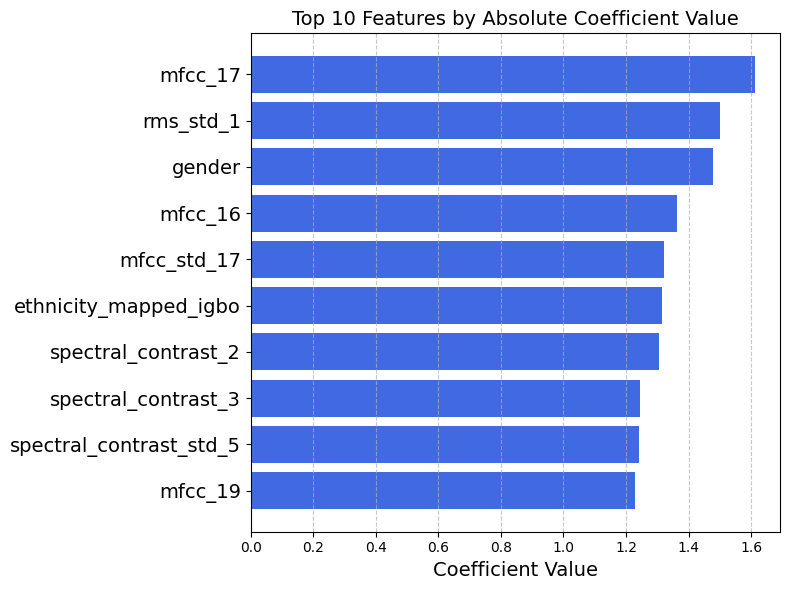

In [19]:
best_pipe = gscv_mm_nopca.best_estimator_
regressor = best_pipe.named_steps['classifier']
coefficients = regressor.coef_
feature_names = X_df.columns
sorted_coefficients = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)
features = [feature for feature, _ in sorted_coefficients[:10]]
coefficients = [coefficient for _, coefficient in sorted_coefficients[:10]]
plt.figure(figsize=(8, 6))
plt.barh(features, coefficients, color='royalblue')
plt.xlabel("Coefficient Value", fontsize=14)
plt.yticks(fontsize=14)
plt.title("Top 10 Features by Absolute Coefficient Value",fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
Y_df = Y_df[X_df.columns]
predictions=gscv_mm_nopca.predict(Y_df)
prediction=predictions.round()
predictions_df = pd.DataFrame({
    'Id': eval_df['Id'],
    'Predicted': prediction
})
predictions_df.to_csv('DSL_Winter_Project_2025/predictionsfinal.csv', index=False)